# BAN5753 EXERCISE 2

## Part I

1.	Build a regression model to predict Satisf using only dealers’ perceived importance about choosing a supplier of hydraulic and pneumatic products. Variable names in the data are Reliab2, Time2, ….,Return2, Warranty2 as independent variables.

In [1]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
# import necessary package to handle excel workbook
import openpyxl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.feature_selection import RFE, RFECV
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, norm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# import data
df = pd.read_excel("C:\\Users\\cwolt\\OneDrive\\Desktop\\BAnDS\\Fall 2025\\Advanced Business Analytics\\Module 2\\BFP1_Data.xlsx")
df.head()

,id,colrcode,reliab,time,av_br,av_spec,price,credit,av_pay,return,...,fn_newpr,fn_need,fn_order,fn_pric,fn_other,pr_area,sales,num_emp,industry,size
0,1,8.0,8.0,8.0,6.0,7.0,7.0,5.0,8.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,6.0,34.0,large
1,5,8.0,9.0,9.0,9.0,9.0,9.0,7.0,6.0,8.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,5.0,30.0,NaN
2,9,5.0,8.0,7.0,4.0,8.0,5.0,1.0,1.0,5.0,...,0.0,1.0,0.0,0.0,0.0,2.0,NaN,3.0,34.0,NaN
3,10,8.0,9.0,9.0,6.0,7.0,9.0,9.0,4.0,9.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,99.0,NaN
4,11,8.0,9.0,8.0,7.0,8.0,4.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,5.0,35.0,large


In [3]:
# Show column headers
df.columns

Index(['id', 'colrcode', 'reliab', 'time', 'av_br', 'av_spec', 'price',
       'credit', 'av_pay', 'return', 'warranty', 'talk_dir', 'reliab2',
       'time2', 'av_br2', 'av_spec2', 'price2', 'credit2', 'return2',
       'warrant2', 'satisf', 'rate', 'percent', 'i_acces', 'purch_i',
       'purch_i2', 'purchgrp', 'often', 'rout_int', 'rout_cal', 'rout_sal',
       'rout_no', 'fn_tech', 'fn_newpr', 'fn_need', 'fn_order', 'fn_pric',
       'fn_other', 'pr_area', 'sales', 'num_emp', 'industry', 'size'],
      dtype='object')

In [4]:
# transpose the outpute of the df
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,317.0,637.192429,403.014979,1.0,283.0,622.0,959.0,1355.0
colrcode,316.0,4.889241,2.597388,1.0,2.0,5.0,8.0,8.0
reliab,313.0,8.456869,1.046465,1.0,8.0,9.0,9.0,9.0
time,313.0,8.434505,0.931822,2.0,8.0,9.0,9.0,9.0
av_br,311.0,6.617363,1.750084,1.0,6.0,7.0,8.0,9.0
av_spec,311.0,7.636656,1.538686,2.0,7.0,8.0,9.0,9.0
price,313.0,7.421725,1.627422,1.0,7.0,8.0,9.0,9.0
credit,308.0,5.827922,2.248329,1.0,5.0,6.0,7.0,9.0
av_pay,309.0,3.417476,2.340458,1.0,1.0,3.0,5.0,9.0
return,310.0,6.709677,1.809603,1.0,5.0,7.0,8.0,9.0


In [5]:
model_df = df[['satisf', 'reliab2', 'time2', 'av_br2', 'av_spec2', 'price2', 'credit2', 'return2', 'warrant2']].dropna()
# check for null values in subsetted data
model_df.isnull().sum()

satisf      0
reliab2     0
time2       0
av_br2      0
av_spec2    0
price2      0
credit2     0
return2     0
warrant2    0
dtype: int64

In [6]:
# checking the data types of the columns to ensure they can be used for model building
model_df.dtypes

satisf      float64
reliab2     float64
time2       float64
av_br2      float64
av_spec2    float64
price2      float64
credit2     float64
return2     float64
warrant2    float64
dtype: object

In [7]:
# define the model formula
ols_formula = """
satisf ~ 
reliab2 + 
time2 + 
av_br2 + 
av_spec2 + 
price2 + 
credit2 + 
return2 + 
warrant2
"""
# fit the regression model and print the model diagnostics
linear_model = smf.ols(ols_formula, model_df).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 satisf   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     56.15
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.94e-53
Time:                        17:05:04   Log-Likelihood:                -469.59
No. Observations:                 283   AIC:                             957.2
Df Residuals:                     274   BIC:                             990.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0266      0.481      4.213      0.000       1.080       2.974
reliab2        0.8019      0.086      9.360      0.000       0.633       0.971
time2          0.1481      0.073      2.033      0.043       0.005       0.291
av_br2        -0.0839      0.073     -1.150      0.251      -0.227       0.060
av_spec2       0.0649      0.065      1.002      0.317      -0.063       0.192
price2         0.0597      0.061      0.977      0.330      -0.061       0.180
credit2       -0.2610      0.067     -3.910      0.000      -0.392      -0.130
return2        0.2223      0.091      2.432      0.016       0.042       0.402
warrant2       0.0077      0.089      0.087      0.931      -0.167       0.183
==============================================================================
Omnibus:                       48.358   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.073
Skew:                          -0.546   Prob(JB):                     1.00e-53
Kurtosis:                       7.417   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# to calculate RMSE and CV
# residuals and mean of Y
residuals = linear_model.resid
mean_y = model_df['satisf'].mean()

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(residuals**2))

# Coefficient of Variation (CV)
cv = (rmse / mean_y) * 100

print(f"RMSE: {rmse:.3f}")
print(f"CV: {cv:.2f}%")


RMSE: 1.272
CV: 14.70%


## Part II
2.	Create a new variable (name it as Avg_Score) by averaging the three variables, Satisf, Rate and Percent. Then, run a stepwise regression with Avg_Score as dependent variable and Time2,……, Return2, Warrant2 as well as I_access, Puch_I, pr_area, num_emp and Industry as independent variables. Use p-value to enter as 0.05 and p-value to stay as 0.05.

In [9]:
# create new variable for average_score
df['Avg_Score'] = df[['satisf', 'rate', 'percent']].mean(axis=1)
print(df[['satisf','rate','percent','Avg_Score']].head())


   satisf  rate  percent  Avg_Score
0     9.0   7.0      2.0   6.000000
1     6.0   6.0      2.0   4.666667
2     NaN   NaN      1.0   1.000000
3     3.0   2.0      1.0   2.000000
4     9.0   7.0      1.0   5.666667


In [10]:
# create new df for stepwise regression model
feature_cols = [
    'time2','av_br2','av_spec2','price2','credit2','return2','warrant2',
    'i_acces','purch_i','pr_area','num_emp','industry'
]
# add new variable
model_df2 = df[feature_cols + ['Avg_Score']].copy()

# check for all null values
model_df2.isnull().sum()
model_df2.dropna(axis=0, how = 'any', inplace=True)


In [11]:
model_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273 entries, 0 to 316
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time2      273 non-null    float64
 1   av_br2     273 non-null    float64
 2   av_spec2   273 non-null    float64
 3   price2     273 non-null    float64
 4   credit2    273 non-null    float64
 5   return2    273 non-null    float64
 6   warrant2   273 non-null    float64
 7   i_acces    273 non-null    float64
 8   purch_i    273 non-null    float64
 9   pr_area    273 non-null    float64
 10  num_emp    273 non-null    float64
 11  industry   273 non-null    float64
 12  Avg_Score  273 non-null    float64
dtypes: float64(13)
memory usage: 29.9 KB


In [12]:
def _model_data_subset(
    input_data: pd.DataFrame,
    column_subset: list = None,
    target_variable_name: str = None
) -> pd.DataFrame:
  
    if column_subset is None:
        return input_data.copy()

    cols = column_subset.copy()

    if target_variable_name is not None and target_variable_name not in cols:
        cols.append(target_variable_name)

    return input_data[cols].copy()


In [ ]:
def _stepwise_selection_p_val(
        input_dataframe: pd.DataFrame,
        target_variable_name: str,
        column_subset: list = None,
        SL_in: float = 0.05,
        SL_out: float = 0.05,
) -> [pd.DataFrame, pd.Series, list]:  # type: ignore
    model_subset_data = _model_data_subset(
        input_dataframe, column_subset, target_variable_name=target_variable_name
    )
    model_subset_data_nona = model_subset_data.dropna()

    target = model_subset_data_nona[target_variable_name]
    x_variables_subset_data = model_subset_data_nona.drop(target_variable_name, axis=1)

    initial_features = x_variables_subset_data.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype=float)
        for new_column in remaining_features:
            model = sm.OLS(
                target,
                sm.add_constant(x_variables_subset_data[best_features + [new_column]]),
            ).fit()
            new_pval[new_column] = model.pvalues.get(new_column, np.nan)

        min_p_value = new_pval.min()
        if np.isnan(min_p_value) or min_p_value >= SL_in:
            break

        best_features.append(new_pval.idxmin())

        while len(best_features) > 0:
            best_features_with_constant = sm.add_constant(
                x_variables_subset_data[best_features]
            )
            p_values = sm.OLS(target, best_features_with_constant).fit().pvalues.drop('const', errors='ignore')
            if p_values.empty or p_values.isna().all():
                break
            max_p_value = p_values.max()
            if max_p_value >= SL_out:
                excluded_feature = p_values.idxmax()
                best_features.remove(excluded_feature)
            else:
                break

    return x_variables_subset_data, target, best_features


In [14]:
def build_linear_regression_stepwise_based(
        input_dataframe: pd.DataFrame,
        target_variable_name: str,
        column_subset: list = None,
        SL_in: float = 0.05,
        SL_out: float = 0.05,
) -> [list, list]:
    x_variable_subset_data, target_variable, best_features = _stepwise_selection_p_val(
        input_dataframe, target_variable_name, column_subset, SL_in=SL_in, SL_out=SL_out
    )
    dataframe_subset_best_features = x_variable_subset_data[best_features]
    regression_model = sm.OLS(
        target_variable, sm.add_constant(dataframe_subset_best_features)
    ).fit()
    print("The best features are ", best_features)
    return regression_model.summary(), regression_model


In [ ]:
SL_in = 0.05  # entry p-value
SL_out = 0.05 # exit p-value

step_summary, final_model = build_linear_regression_stepwise_based(
    model_df2, target_variable_name='Avg_Score',
    column_subset=feature_cols, SL_in=SL_in, SL_out=SL_out
)
print(step_summary)  # optional


The best features are  ['time2', 'i_acces', 'av_spec2']


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              Avg_Score   R-squared:                       0.398
 Model:                            OLS   Adj. R-squared:                  0.391
 Method:                 Least Squares   F-statistic:                     59.32
 Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.82e-29
 Time:                        17:05:04   Log-Likelihood:                -411.40
 No. Observations:                 273   AIC:                             830.8
 Df Residuals:                     269   BIC:                             845.2
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

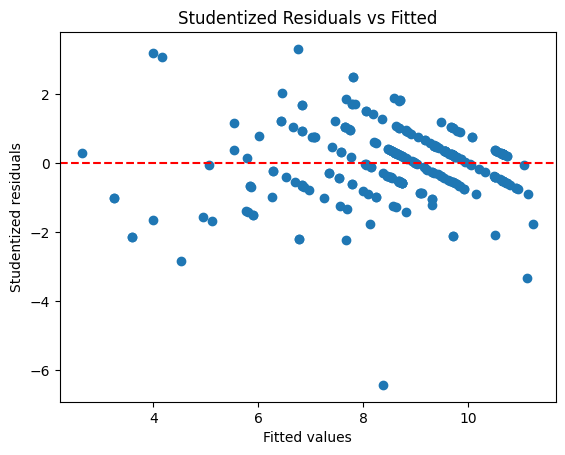

In [16]:
# studentized residuals
studentized_residuals = linear_model.get_influence().resid_studentized_internal
fitted_values = linear_model.fittedvalues

plt.scatter(fitted_values, studentized_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Studentized residuals")
plt.title("Studentized Residuals vs Fitted")
plt.show()


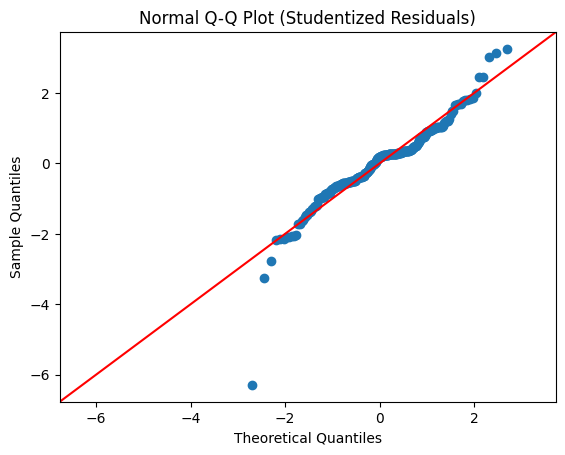

In [17]:
# create normality of residual plot 
studentized_residuals = linear_model.get_influence().resid_studentized_internal

sm.qqplot(studentized_residuals, line='45', fit=True)
plt.title("Normal Q-Q Plot (Studentized Residuals)")
plt.show()

In [18]:
# create a shapiro-wilks test for normality
shapiro_stat, shapiro_p = shapiro(studentized_residuals)
print(f"Shapiro–Wilk test: W={shapiro_stat:.3f}, p-value={shapiro_p:.4f}")

if shapiro_p < 0.05:
    print("Shapiro–Wilk suggests residuals deviate significantly from normality (reject H0).")
else:
    print("Shapiro–Wilk suggests no significant deviation from normality (fail to reject H0).")


Shapiro–Wilk test: W=0.932, p-value=0.0000
Shapiro–Wilk suggests residuals deviate significantly from normality (reject H0).


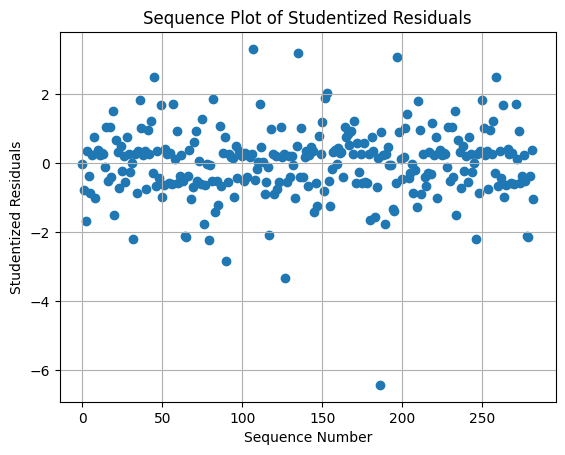

In [19]:
# create a sequence plot
plt.scatter(range(len(studentized_residuals)), studentized_residuals)
plt.grid()
plt.xlabel("Sequence Number")
plt.ylabel("Studentized Residuals")
plt.title("Sequence Plot of Studentized Residuals")
plt.show()

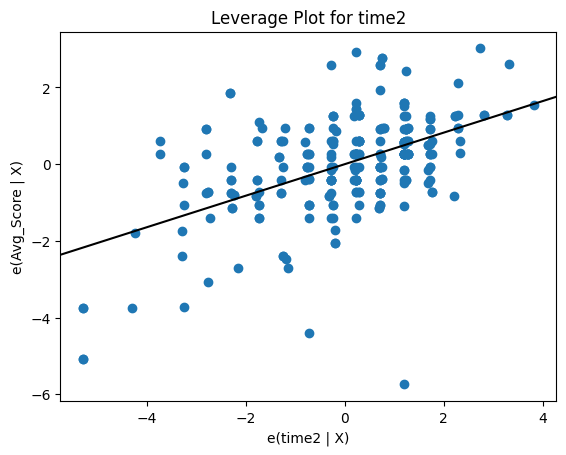

In [20]:
# leverage plot for time2
sm.graphics.plot_partregress(
    endog='Avg_Score',       # dependent variable
    exog_i='time2',          # variable of interest
    exog_others=['i_acces', 'av_spec2'],  # other predictors in the model
    data=model_df2,          # dataframe with variables
    obs_labels=False
)
plt.title("Leverage Plot for time2")
plt.show()

In [21]:
# report VIF
# Select only the predictors retained model
X = model_df2[['time2', 'i_acces', 'av_spec2']]

# Add constant for intercept
X_const = sm.add_constant(X)

# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) 
                   for i in range(X_const.shape[1])]

print(vif_data)

   Variable        VIF
0     const  30.388447
1     time2   1.271669
2   i_acces   1.028082
3  av_spec2   1.291528
